Dataset URL: http://www.kaggle.com/c/job-salary-prediction

Using only the Train_rev1.csv

## Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import GridSearchCV

In [4]:
train_data = pd.read_csv("Train_rev1.csv")
# selected_data = train_data.sample(n=2500, random_state=42) # randomly select 2500 data points

## Save to new data file to prevent using the big data every time
# selected_data.to_csv("selected_salary_data.csv"bb, index=False) 

In [7]:
data = train_data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


In [2]:
data = pd.read_csv("selected_salary_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  2500 non-null   int64 
 1   Title               2500 non-null   object
 2   FullDescription     2500 non-null   object
 3   LocationRaw         2500 non-null   object
 4   LocationNormalized  2500 non-null   object
 5   ContractType        685 non-null    object
 6   ContractTime        1859 non-null   object
 7   Company             2157 non-null   object
 8   Category            2500 non-null   object
 9   SalaryRaw           2500 non-null   object
 10  SalaryNormalized    2500 non-null   int64 
 11  SourceName          2500 non-null   object
dtypes: int64(2), object(10)
memory usage: 234.5+ KB


In [13]:
data.head(5)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [9]:
data.describe()

,Id,SalaryNormalized
count,2.447680e+05,244768.000000
mean,6.970142e+07,34122.577576
std,3.129813e+06,17640.543124
min,1.261263e+07,5000.000000
25%,6.869550e+07,21500.000000
50%,6.993700e+07,30000.000000
75%,7.162606e+07,42500.000000
max,7.270524e+07,200000.000000


## EDA & Preprocess

### Categorical Variables

In [10]:
unique_location = data['LocationNormalized'].nunique()
unique_source = data['SourceName'].nunique()

location = data['LocationNormalized'].value_counts()
contract_type = data['ContractType'].value_counts()
contract_time = data['ContractTime'].value_counts()
source = data['SourceName'].value_counts()

print('Number of Unique Location:', unique_location, ', Location Category (Top 5):')
print(location.head(5))
print('-----------------------')
print('Contract Type Category:')
print(contract_type)
print('-----------------------')
print('Contract Time Category:')
print(contract_time)
print('-----------------------')
print('Number of Unique Source:', unique_source, ', Source Category (Top 5):')
print(source.head(5))

Number of Unique Location: 2732 , Location Category (Top 5):
LocationNormalized
UK                   41093
London               30522
South East London    11713
The City              6678
Manchester            3516
Name: count, dtype: int64
-----------------------
Contract Type Category:
ContractType
full_time    57538
part_time     7904
Name: count, dtype: int64
-----------------------
Contract Time Category:
ContractTime
permanent    151521
contract      29342
Name: count, dtype: int64
-----------------------
Number of Unique Source: 167 , Source Category (Top 5):
SourceName
totaljobs.com       48149
cv-library.co.uk    34279
Jobcentre Plus      17929
jobsite.co.uk       12225
cwjobs.co.uk         7011
Name: count, dtype: int64


### Missing Values

In [14]:
missing_value = data.isna().sum()
print('Missing values:')
print(missing_value)

Missing values:
Id                         0
Title                      1
FullDescription            0
LocationRaw                0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryRaw                  0
SalaryNormalized           0
SourceName                 1
dtype: int64


In [15]:
data.fillna('', inplace=True)
missing_value = data.isna().sum()
print('Missing values:')
print(missing_value)

Missing values:
Id                    0
Title                 0
FullDescription       0
LocationRaw           0
LocationNormalized    0
ContractType          0
ContractTime          0
Company               0
Category              0
SalaryRaw             0
SalaryNormalized      0
SourceName            0
dtype: int64


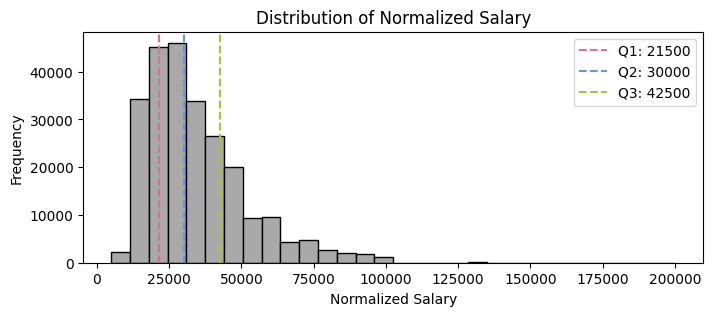

In [16]:
Q1 = data['SalaryNormalized'].quantile(0.25)
Q2 = data['SalaryNormalized'].quantile(0.5)
Q3 = data['SalaryNormalized'].quantile(0.75)

plt.figure(figsize=(8, 3))
plt.hist(data['SalaryNormalized'], bins=30, color='darkgrey', edgecolor='black')
plt.title('Distribution of Normalized Salary')
plt.xlabel('Normalized Salary')
plt.ylabel('Frequency')

plt.axvline(x=Q1, color='palevioletred', linestyle='--', label='Q1: {}'.format(int(Q1)))
plt.axvline(x=Q2, color='cornflowerblue', linestyle='--', label='Q2: {}'.format(int(Q2)))
plt.axvline(x=Q3, color='yellowgreen', linestyle='--', label='Q3: {}'.format(int(Q3)))

plt.legend()
plt.show()

### Identify high/low salary

In [17]:
process_data = data.copy()

process_data['HighSalary'] = (process_data['SalaryNormalized'] >= Q3).astype(int)

process_data.head(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,HighSalary
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,0
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,0
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,0


### Feature selection

In [18]:
process_data['Text'] = process_data['Title'] + ' ' + process_data['FullDescription'] + ' ' + \
    process_data['LocationNormalized'] + ' ' + process_data['ContractType'] + ' ' + \
    process_data['ContractTime'] + ' ' + process_data['Category'] + ' ' + process_data['SourceName'] 

### Preprocess and Lemmatization

In [19]:
clean_data = process_data.copy()

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

stop_words_set = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def pre_process(text, apply_lemmatization=False):
    # lowercase
    text=str(text).lower()

    # remove numbers followed by dot (like, "1.", "2.", etc)
    text=re.sub(r'[^\s]*[0-9]+[^\s]*', "", text)
    
    #remove tags
    text=re.sub(r"&lt;/?.*?&gt;"," &lt;&gt; ",text)

    #remove urls
    text=re.sub(r'[^\s]*(\.com|www\.|\.co\.uk)[^\s]*', "", text)

    #remove stars
    text=re.sub(r'[^\s]*[\*]+[^\s]*', "", text)
    
    # correct some misspellings and/or replace some text with others that might be easier to handle
    text=text.replace('do not', "don't")
    
    # remove special characters except spaces, apostrophes and dots
    text=re.sub(r"[^a-zA-Z0-9.']+", ' ', text)

    # remove typical non-informative text
    non_informative = ['work', 'experience', 'role', 'working', 'within', 'job', 'position', 'jobs', 'company']
    text=' '.join(word for word in text.split() if word not in non_informative)
    
    # lemmatization and remove stop words
    if apply_lemmatization:
        words = text.split()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words_set]
        text = ' '.join(lemmatized_words)
    else:
        text = ' '.join([word for word in text.split() if word not in stop_words_set])
    
    return text

### Two version of clean data

In [20]:
clean_data['Text_process'] = clean_data['Text'].apply(pre_process)
clean_data['Text_process_Lem'] = clean_data['Text'].apply(lambda x: pre_process(x, apply_lemmatization=True))

In [21]:
X_no_lem = clean_data['Text_process']
X_lem = clean_data['Text_process_Lem']
y = clean_data['HighSalary']

### Train Test Split

In [22]:
X_no_lem_train, X_no_lem_test, y_train, y_test = train_test_split(X_no_lem, y, test_size=0.2, random_state=42)
X_lem_train, X_lem_test, y_train, y_test = train_test_split(X_lem, y, test_size=0.2, random_state=42)

## Model

### Count Vectorizer

In [26]:
count_vect = CountVectorizer(stop_words='english')

X_no_lem_train_count = count_vect.fit_transform(X_no_lem_train)
X_no_lem_test_count = count_vect.transform(X_no_lem_test)

X_lem_train_count = count_vect.fit_transform(X_lem_train)
X_lem_test_count = count_vect.transform(X_lem_test)

# Naive Bayes Model for No Lemmatization
nb_no_lem_count = MultinomialNB()
nb_no_lem_count.fit(X_no_lem_train_count, y_train)

# Naive Bayes Model for Lemmatization
nb_lem_count = MultinomialNB()
nb_lem_count.fit(X_lem_train_count, y_train)

# Prediction and Evaluation
y_pred_no_lem_count = nb_no_lem_count.predict(X_no_lem_test_count)
y_pred_lem_count = nb_lem_count.predict(X_lem_test_count)
print("Accuracy (No Lemmatization):", accuracy_score(y_test, y_pred_no_lem_count))
print("Classicication Report (No Lemmatization):")
print(classification_report(y_test, y_pred_no_lem_count))
print("Accuracy (Lemmatization):", accuracy_score(y_test, y_pred_lem_count))
print("Classicication Report (Lemmatization):")
print(classification_report(y_test, y_pred_lem_count))

Accuracy (No Lemmatization): 0.7894145524369817
Classicication Report (No Lemmatization):
              precision    recall  f1-score   support

           0       0.92      0.78      0.85     36453
           1       0.56      0.81      0.66     12501

    accuracy                           0.79     48954
   macro avg       0.74      0.80      0.76     48954
weighted avg       0.83      0.79      0.80     48954

Accuracy (Lemmatization): 0.788107202680067
Classicication Report (Lemmatization):
              precision    recall  f1-score   support

           0       0.92      0.78      0.85     36453
           1       0.56      0.81      0.66     12501

    accuracy                           0.79     48954
   macro avg       0.74      0.80      0.75     48954
weighted avg       0.83      0.79      0.80     48954



### TFIDF Vectorizer

In [27]:
tfidf_vect = TfidfVectorizer(stop_words='english')

X_no_lem_train_tdidf = tfidf_vect.fit_transform(X_no_lem_train)
X_no_lem_test_tdidf = tfidf_vect.transform(X_no_lem_test)

X_lem_train_tdidf = tfidf_vect.fit_transform(X_lem_train)
X_lem_test_tdidf = tfidf_vect.transform(X_lem_test)

# Naive Bayes Model for No Lemmatization
nb_no_lem_tdidf = MultinomialNB()
nb_no_lem_tdidf.fit(X_no_lem_train_tdidf, y_train)

# Naive Bayes Model for Lemmatization
nb_lem_tdidf = MultinomialNB()
nb_lem_tdidf.fit(X_lem_train_tdidf, y_train)

# Prediction and Evaluation
y_pred_no_lem_tdidf = nb_no_lem_tdidf.predict(X_no_lem_test_tdidf)
y_pred_lem_tdidf = nb_lem_tdidf.predict(X_lem_test_tdidf)
print("Accuracy (No Lemmatization):", accuracy_score(y_test, y_pred_no_lem_tdidf))
print("Classicication Report (No Lemmatization):")
print(classification_report(y_test, y_pred_no_lem_tdidf))
print("Accuracy (Lemmatization):", accuracy_score(y_test, y_pred_lem_tdidf))
print("Classicication Report (Lemmatization):")
print(classification_report(y_test, y_pred_lem_tdidf))

Accuracy (No Lemmatization): 0.8231400906973894
Classicication Report (No Lemmatization):
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     36453
           1       0.76      0.45      0.57     12501

    accuracy                           0.82     48954
   macro avg       0.80      0.70      0.73     48954
weighted avg       0.82      0.82      0.81     48954

Accuracy (Lemmatization): 0.8196674429055848
Classicication Report (Lemmatization):
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     36453
           1       0.76      0.43      0.55     12501

    accuracy                           0.82     48954
   macro avg       0.79      0.69      0.72     48954
weighted avg       0.81      0.82      0.80     48954



**By comparing the results, I decide to continue with the no lemmatization data.**

For count vectorizer, the no lemmatization version performs better by having higher recall and f1 score.

For tfidf vectorizer, the no lemmatization version performs better by having higher recall and f1 score.

I will decide on the vectorizer in the tuning phase.

### Hyperparameter Tuning

In this step, I will find out the best n_gram and the best vectorizer for this dataset.

In [28]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('clf', MultinomialNB()),
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3)],  # unigrams, bigrams, uni+bi, uni+bi+tri
    'vect': [CountVectorizer(stop_words='english'), TfidfVectorizer(stop_words='english')],  # Testing both vectorizers
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)

# Assuming X_no_lem_train and y_train are your training data and labels
grid_search.fit(X_no_lem_train, y_train)

print("Best Score: %s" % grid_search.best_score_)
print("Best Parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(1, 1); total time= 1.1min
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(1, 1); total time= 1.1min
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(1, 1); total time= 1.1min
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(1, 1); total time= 1.1min
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(1, 1); total time= 1.2min
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(1, 2); total time=49.7min
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(2, 2); total time=52.3min
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(2, 2); total time=51.8min
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(2, 2); total time=54.0min
[CV] END vect=CountVectorizer(stop_words='english'), vect_

In [1]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 1))),
    ('clf', MultinomialNB()),
])

pipeline.fit(X_no_lem_train, y_train)
y_pred = pipeline.predict(X_no_lem_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classicication Report:")
print(classification_report(y_test, y_pred))

NameError: name 'Pipeline' is not defined

# Final Model Accuracy: 0.794

# Final Model Confusion Matrix

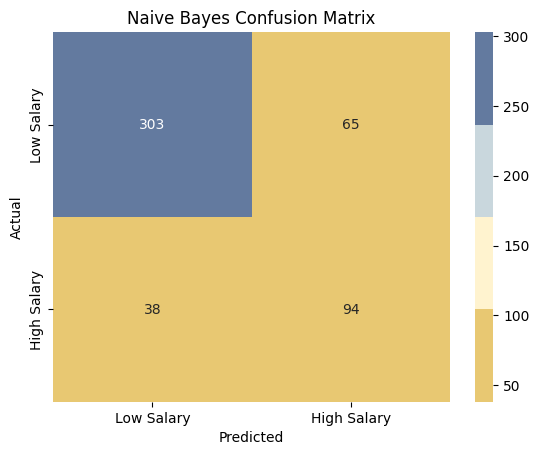

In [20]:
palette = ['#E8C872', '#FFF3CF', '#C9D7DD', '#637A9F']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap=sns.color_palette(palette, as_cmap=True), 
            xticklabels=['Low Salary', 'High Salary'], yticklabels=['Low Salary', 'High Salary'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

In [21]:
# Access the vectorizer and classifier from the pipeline
vectorizer = pipeline.named_steps['vect']
classifier = pipeline.named_steps['clf']

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get log probability of features given a class
low_salary_prob_sorted = classifier.feature_log_prob_[0, :].argsort()
high_salary_prob_sorted = classifier.feature_log_prob_[1, :].argsort()

# Top 10 words for each class
top10_low = [feature_names[i] for i in low_salary_prob_sorted[-10:]]
top10_high = [feature_names[i] for i in high_salary_prob_sorted[-10:]]

print("Top 10 words for class 0 (low salary):", top10_low)
print("Top 10 words for class 1 (high salary):", top10_high)

only_low = [word for word in top10_low if word not in top10_high]
only_high = [word for word in top10_high if word not in top10_low]

print("Words within top 10 words only for class 0 (low salary):", only_low)
print("Words within top 10 words only for class 1 (high salary):", only_high)

Top 10 words for class 0 (low salary): ['service', 'management', 'support', 'client', 'permanent', 'business', 'skills', 'manager', 'sales', 'team']
Top 10 words for class 1 (high salary): ['support', 'project', 'permanent', 'client', 'skills', 'development', 'management', 'manager', 'team', 'business']
Words within top 10 words only for class 0 (low salary): ['service', 'sales']
Words within top 10 words only for class 1 (high salary): ['project', 'development']


There are many similar words within the top 10 words for both salary group, such as **_management_**, **_support_**, **_client_**, **_business_**, **_skills_**, **_teams_**.

However, when filtering out the unique words. We can see that the most frequent words among the top 10 words for lower salary group is **_service_** and **_sales_**. The most frequent words among the top 10 words for high salary group is **_project_** and **_development_**.

Therefore, we can assume that within this dataset, the lower salary jobs are more related to service work while the higher salary jobs are more related to development work. This is valid because development work might require more education and experiences than the service work.

# Further Improve Accuracy

There are several ways to improve accuracy

**In the preprocessing phase**:
 - _Data Cleaning_
    - Null value imputation (done)
    - Text concatenation
        - In the current version, I concatenated all the text columns into one text column. **However, we can further analyze which are the necessary and informative columns and only concatenate those columns for model training**.
    - Basic text cleaning such as lowercasing, special character removal (done)
    - Stop word removal (done)
    - Non-informative text removal
        - Certain type of datasets always have their own set of non-informative words. For example, 'work', 'experience' and 'job' are some non-informative words for this dataset. I manually recognized several of these words and removed them. **However, if these dataset-specific non-informative words can be identified better, the accuracy of the model will increase**.
- _Features Engineering_
    - Adding sentimental analysis as a feature is usually helpful for text analytics project. However, it might have less impact on accuracy for this particular dataset.
            
- _Data Lemmatization_ 
    - I have tried lemmatization after the current data cleaning method and it does not improve the accuracy. **However, with different data cleaning method, lemmatization might still be helpful and bring up model accuracy**.
    
**In the tuning phase**:
- _Grid Search_
    - n gram
        - I have tried using different n gram combinations (unigram, bigram, uni+bi, uni+bi+tri) The result shows that unigram gives the best result. **With different data preprocessing steps, this step can improve accuracy**.
    - vectorizer
        - I have tried using count vectorizer and TFIDF vectorizer. However, as count vectorizer suit the Naive Bayes better than the other one, grid search on these two vectorizer did not improve the accuracy.